# Using NER model to extract Bio relate sentence
Using NER to extract key sentece, we can fast to read whole bunch of paper.
* Using Scispacy ner model to extract bio entity
* Mark the extract entity and extract the bio relate sentence
* Visualize the sentence by using Ipywidgets

## P.S. Ipywidget only enable in edit mode
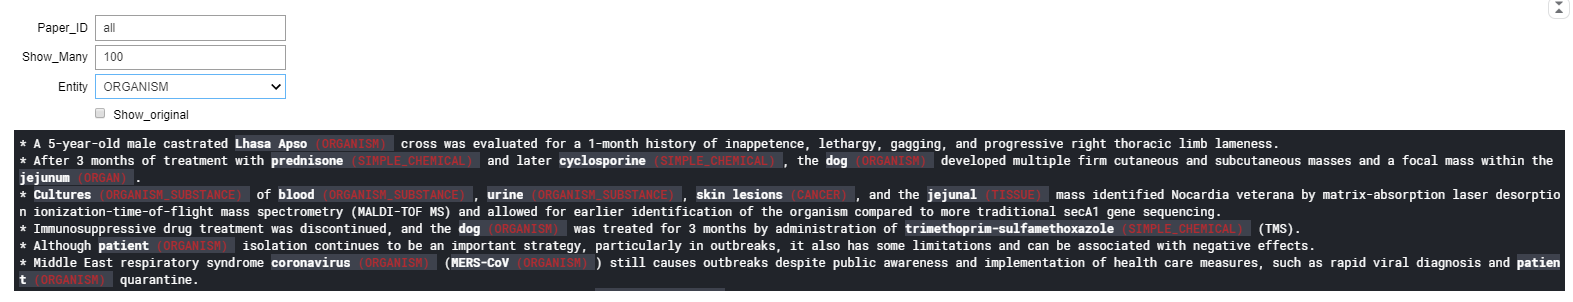

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from tqdm import tqdm

# Input data files are available in the "../input/" directory.
#####################################################################################
#thanks for your work vasuji https://www.kaggle.com/vasuji/i-covid19-nlp-data-parsing
#####################################################################################
datafiles = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ifile = os.path.join(dirname, filename)
        if ifile.split(".")[-1] == "json":
            datafiles.append(ifile)

## Load Data
* Update key error for abstract and bodytext

In [ ]:
id2title = []
for file in datafiles:
    with open(file,'r')as f:
        doc = json.load(f)
    id = doc['paper_id'] 
    title = doc['metadata']['title']
    id2title.append({id:title})

print ('finish load title')

id2abstract = []
for file in datafiles:
    with open(file,'r')as f:
        doc = json.load(f)
    id = doc['paper_id'] 
    abstract = ''
    try:
        for item in doc['abstract']:
            abstract = abstract + item['text']
            
        id2abstract.append({id:abstract})
    except KeyError:
        None
    
print ('finish load abstract')    
     
id2bodytext = []
for file in datafiles:
    with open(file,'r')as f:
        doc = json.load(f)
    id = doc['paper_id'] 
    bodytext = ''
    try:
        for item in doc['body_text']:
            bodytext = bodytext + item['text']
            
        id2bodytext.append({id:bodytext})
    except KeyError:
        None
print ('finish load bodytext')

## Install SciSpacy
* Package for NER model : https://allenai.github.io/scispacy/

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz
!pip install scispacy

In [ ]:
import scispacy
import en_ner_bionlp13cg_md
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker
from nltk import tokenize

## Load Model 

In [ ]:
nlp = en_ner_bionlp13cg_md.load()

## Extract Key Sentence on all paper abstract
* I didn't extract on bodytext, it takes too much time (exceed the kernel time limit)
* Only run on 100 data, it's an example to use NER

In [ ]:
sentence_list=[]
sentence_list_without_col = []
ID_list = []
ent_type_all_check = []
ent_type_all= []
for i in tqdm(range(len(id2abstract[:100]))):
    ID = list(id2abstract[i].keys())[0]
    text = list(id2abstract[i].values())[0]
    a = tokenize.sent_tokenize(text) # Split Sentence
    for sent in a:
        print_flag = False
        doc = nlp(sent)
        count_label =0
        ent_type = ''
        check_dupl =[]
        sent_withcol = sent
        sent_withoutcol = sent
        for x in doc.ents:
            if x.text not in check_dupl:
                sent_withcol = sent_withcol.replace(x.text,f"\033[1;40m{x.text}\033[1;31;40m ({x.label_}) \033[00m")
                sent_withoutcol = sent_withoutcol.replace(x.text,f"{x.text} *{x.label_}*")
                check_dupl.append(x.text)
                print_flag =True

            if x.label_ not in ent_type:
                ent_type+= f'{x.label_}, '
                ent_type_all_check.append(x.label_)
                
        if print_flag== True:
            sentence_list.append('* '+sent_withcol)
            sentence_list_without_col.append('* '+sent)
            ent_type_all.append(ent_type)
            ID_list.append(ID)

In [ ]:
len(ID_list),len(sentence_list),len(sentence_list_without_col),len(ent_type_all)

In [ ]:
pd_all = pd.DataFrame({'Paper_ID':ID_list,'Sentence_col':sentence_list,'Sentence_wo_col':sentence_list_without_col,'NER_Key':ent_type_all})

In [ ]:
type_list = pd.Series(ent_type_all_check).unique().tolist() # Entity type

## Ipywidgets for Visaulize the text

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
def f(Paper_ID='all',Show_Many='100', Entity='ORGANISM', Show_original=False):
    pd_all2 = pd_all.copy()[:int(Show_Many)]
    if Paper_ID != 'all':
        pd_all2 = pd_all[pd_all.Paper_ID==Paper_ID].copy()[:int(Show_Many)]
    pd_all2 = pd_all2[pd_all2['NER_Key'].str.contains(Entity)].reset_index(drop=True)
    for i in range(len(pd_all2)):
        if Show_original==True:
            print (pd_all2['Sentence_wo_col'][i])  
        else:
            print (pd_all2['Sentence_col'][i])    

In [ ]:
interact(f, Paper_ID='all',Show_Many='100',Entity=type_list, Original = False);